# Spotify Song Popularity Analysis & Song Reccomendation Model
In this notebook we looked at Spotify's data and analyzed popularity of songs released from 1921 to 2020. We also built a model which recommends 10 similar songs based on one song's attributes. 


#Importing modules, dependencies, and data

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from itertools import chain, combinations
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from matplotlib import rcParams


Mounting our google drive, where the `.csv` is kept

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading the file in our drive and loading it as `df`

In [4]:
df = pd.read_csv('/content/drive/Shareddrives/Project_2/spotify_tracks.csv')
df_copy=df.copy()
df.head(3)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339


Now, we can use pandas' built-in `.info()` function to learn more about our data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

As seen above almost all of our 19 columns are either integers or floats.Four columns: `artists`,`id`,`name`, and `release_date` have a type of a object which we will change later in the notebook. The dataset contains 170653 rows and we can also see that there is no missing values.

#Data Features Explanations
`valence`:A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).\
`year`: Year when the song was released\
`acousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.\
`artists`: Artists featured in the song\
`danceability`:Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.\
`duration_ms`:The duration of the track in milliseconds.\
`energy`:Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.\
`explicit`: Has the value of 1 if a song is exlplicit, 0 if it is not.\
`id`:The Spotify ID for the track.\
`instrumentalness`:Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.\
`key`:The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.\
`liveness`:Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.\
`loudness`:The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.\
`mode`:Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.\
`name`: Title of the song
`popularity`: The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.\
`release_date`: The date song was released\
`speechiness`:Speechiness detects the presence of spoken words in a track.\
`tempo`:The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.\

# Cleaning the Data
We decided to drop `id` and `key` columns as they seemed irrelevant to our analysis. Change `year` data type to 'int64'. We also dropped any duplicate rows and duplicate rows that had the same value for all features except for popularity. We kept the first row out of its duplicates. Duplicates made less than 1% of our data.

After cleaning the data we were left with 168,694 rows and 17 columns.

In [6]:
df = df.drop(['id','key'], axis = 1)
col=df.columns.drop(['popularity'])
duplicate = df[df.duplicated(col)]
df=df.drop(duplicate.index,axis=0)

In [7]:
df.release_date

0               1921
1               1921
2               1921
3               1921
4               1921
             ...    
170648    2020-05-29
170649    2020-10-23
170650    2020-11-03
170651    2020-01-17
170652    2020-10-16
Name: release_date, Length: 168694, dtype: object

After taking a closer look at the `release_date` column we noticed that some dates only had a year and some had year-month-day format. We split the column into year, month, and day and filled missing values with NaN to get an insight into how many of those valuse were missing and if there is anything else we could do with the data we had.

In [8]:
df[['year','month','day']]=df['release_date'].str.split('-',expand=True)
df['artists']=df['artists'].astype('str')
df.year.astype('int64')
df.isna().sum()/df.shape[0]

valence             0.000000
year                0.000000
acousticness        0.000000
artists             0.000000
danceability        0.000000
duration_ms         0.000000
energy              0.000000
explicit            0.000000
instrumentalness    0.000000
liveness            0.000000
loudness            0.000000
mode                0.000000
name                0.000000
popularity          0.000000
release_date        0.000000
speechiness         0.000000
tempo               0.000000
month               0.296578
day                 0.305962
dtype: float64

After spliting `release_date` column we found that around 30% of the rows were missing day and month of the release. Since it was a such a high number we decided to not drop those rows but instead focus on other attributes that could play a significant role for our model.

#Exploratory Data Analysis
In order to see which features and how correlated they are we made a correlation matrix between all columns. Then we wanted to focus just on `popularity` so we plotted a correlation matrix of `popularity` with all the columns.

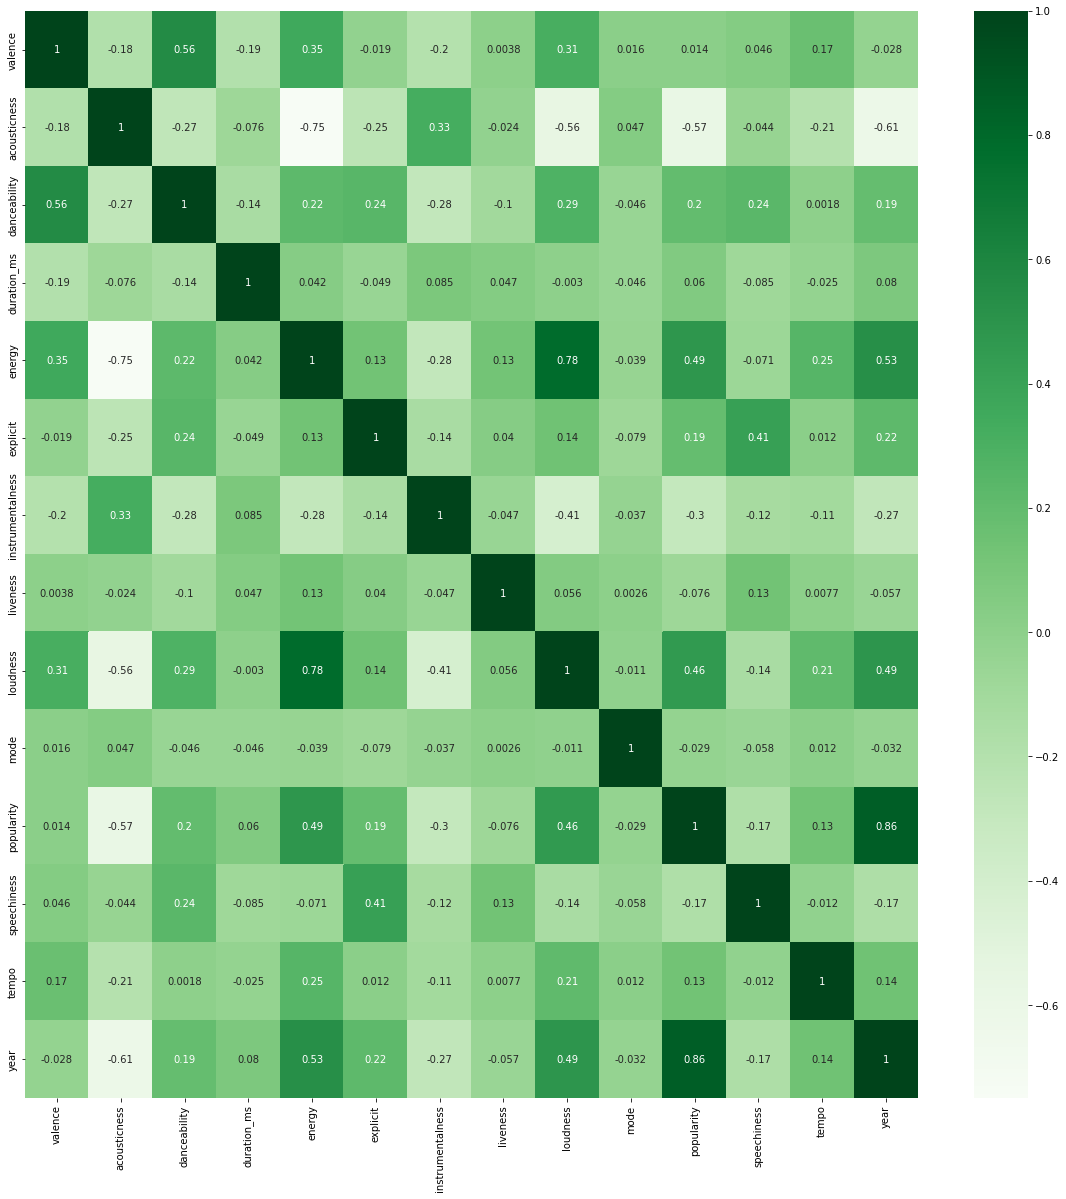

In [9]:
cor = df_copy.corr().loc[['valence', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness'
, 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo', 'year'],['valence', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness'
, 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo','year']]

plt.subplots(figsize=(20, 20))
sns.heatmap(cor,annot=True,cmap="Greens")


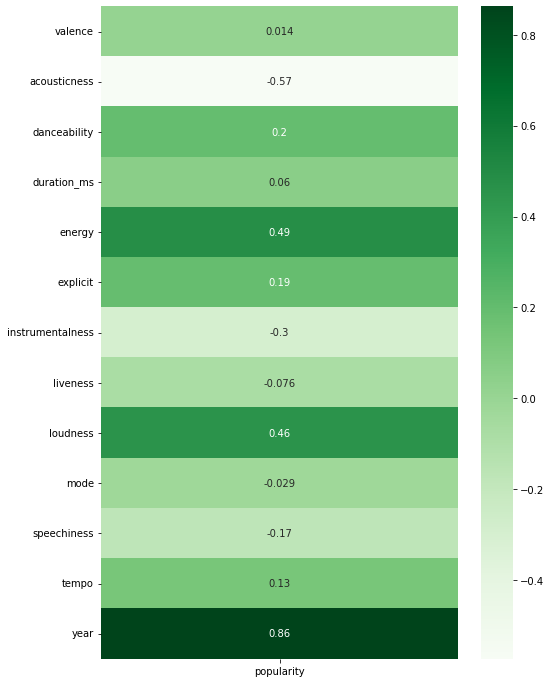

In [10]:
dd = df_copy.corr().loc[['valence', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness'
, 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'year'],['popularity']]
plt.subplots(figsize=(8, 12))
sns.heatmap(dd,annot=True,cmap="Greens")
sns.set(font_scale = 1)


After making two correlation matrices we can notice high positive correlation between `popularity` and `year` with a value of 0.86. It is important to mention `loudness` had a positive correlation of 0.46, and `energy` had a positive correlation of 0.59.
`acousticness` had a negative correlation to `popularity` of - 0.57.

#`Popularity` Distribution
Since our entire project is based on `popularity` we decided to look at the distribution of its values and how they have changed over the years.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


 0: 0.16180777028228627
Above 60: 0.09403416837587585


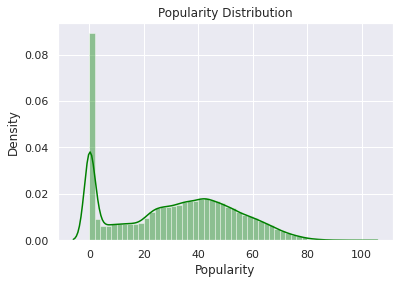

In [11]:
sns.distplot(df['popularity'],color='green').set_title('Popularity Distribution')
plt.xlabel('Popularity')
rcParams['figure.figsize'] = 8,8
sns.set(font_scale = 2)
sns.set(rc={'axes.facecolor':'#D3D3D3'})
print(" 0:",(df['popularity']==0).sum()/df.shape[0])
print("Above 60:",(df['popularity']>60).sum()/df.shape[0])

It is obvious from the histogram that `popularity` has unbalanced set of values. Zeroes make up 16% of all scores and there is only 9% of the data with a score higher than 60.

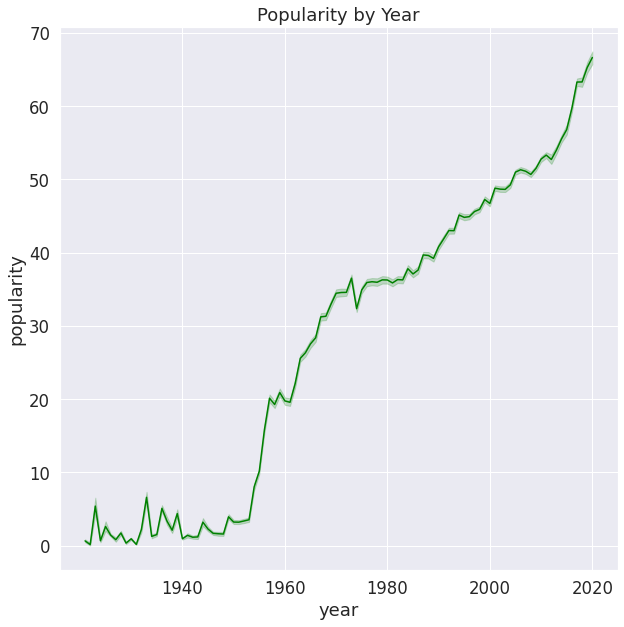

In [62]:
plt.figure(figsize=(10,10))
sns.set(font_scale = 1.5)
sns.lineplot(data = df, x="year", y="popularity", color = 'green').set_title("Popularity by Year")
plt.xticks(['1940','1960','1980','2000','2020'])
plt.show()

We can notice a trend from the graph above. It represents an anverage popularity score over the years. In the recent years the popularity scores tend to get a higher value than in the 1920's, 30's and 40's. 

# Song Recommendation Model
Our goal was to make a model that would recommend 10 songs based on a listener's taste in music. We picked one song to demonstrate how our model works and found 10 songs with most simmilar attributes.

In [13]:
X=df[['valence','year','acousticness' , 'danceability', 'energy', 'explicit','liveness','loudness','mode','speechiness']]
y = df['name']
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(X,y)
ind=neigh.kneighbors(X.iloc[[57331]])[1]
for i in ind:
  print(df.iloc[i][['name', 'artists']])


                                                   name                         artists
57830                                  When You Love Me              ['Memphis Minnie']
39126                             New Orleans Stop Time              ['Memphis Minnie']
1591        Pálida Noche - Instrumental (Remasterizado)            ['Francisco Canaro']
39299     No Seas Malita - Instrumental (Remasterizado)            ['Francisco Canaro']
20628                                    No Seas Amlita            ['Francisco Canaro']
75774                      Quand Il Joue De L'accordéon                      ['Fréhel']
39184  Farolito de papel - Instrumental (Remasterizado)            ['Francisco Canaro']
57871                      En la Trampa - Remasterizado  ['Francisco Canaro', 'Charlo']
20610                      Flores Secas - Remasterizado  ['Francisco Canaro', 'Charlo']
75666   La Guardia Vieja - Instrumental (Remasterizado)            ['Francisco Canaro']


#Linear Regression Model
In this part we made a Linear Regression model to predict `popularity`.\
Firstly, we encoded columns with non-numerical data which were `artists` and `name` in order to use them in our model.

In [14]:
le = LabelEncoder()
for i in df[['artists', 'name']]:
  df[i] = le.fit_transform(df[i])

In [15]:
df.dtypes

valence             float64
year                 object
acousticness        float64
artists               int64
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
instrumentalness    float64
liveness            float64
loudness            float64
mode                  int64
name                  int64
popularity            int64
release_date         object
speechiness         float64
tempo               float64
month                object
day                  object
dtype: object

We decided to train our model based on `popularity` > 60,  60 =<`popularity`< 0, and `popularity`<= 0. We sampled them based on the smallest value count out of the three subsets mentioned above. Concatenating all 3 subsets we made a balanced dataframe. Using this new data frame, we ran the score model to predict the best possible score. Moreover, after receiving score, recreated a linear model based on the new data framed.


In [16]:
pop_df = df[df['popularity']>60]

In [17]:
nonpop_df = df[(df['popularity']<=60) & (df['popularity']>0)].sample(n=pop_df.shape[0])

In [18]:
zero_under_df =df[df['popularity']<=0].sample(n=pop_df.shape[0])

In [19]:
zero_under_df.shape

(15863, 19)

In [20]:
pop_df.shape

(15863, 19)

In [21]:
nonpop_df.shape

(15863, 19)

In [22]:
balanced_df = pd.concat([pop_df,nonpop_df, zero_under_df])

In [23]:
X_score2 = balanced_df[['valence', 'year', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'explicit', 'instrumentalness', 'liveness',
       'loudness', 'mode', 'name', 'popularity','speechiness',
       'tempo']]
y_score2 = balanced_df['popularity']

In order to get a combination of columns that would give us the best score, we made a function `powerset` that tries out all possible combinations and their scores and gives us the best combination of columns and the score our Linear Regression model would have. 

In [24]:
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
lr = LinearRegression()
best_score = 0
best_cols = None
for cols in powerset(X.columns):
  if len(cols) > 1:
    
    lr.fit(X_score2[list(cols)], y_score2)
  
    lr_score = lr.score(X_score2[list(cols)], y_score2)
    if (lr_score > best_score):
      best_score = lr_score
      best_cols = cols

In [25]:
best_score

0.8194215526302258

In [26]:
best_cols

('valence',
 'year',
 'acousticness',
 'danceability',
 'energy',
 'explicit',
 'liveness',
 'loudness',
 'mode',
 'speechiness')

After running `powerset` we found that the highest score we could get was 0.8195 and it would be with these columns: `valence`,
 `year`,
 `acousticness`,
 `danceability`,
 `energy`,
 `explicit`,
 `liveness`,
 `loudness`,
 `mode`,
 `speechiness`.

##Creating Linear Regression Model Based on Best Columns Using Trained Dataframe.
We defined lr as a LinearRegression object and split our X and y variables. Notice how we use our **balanced** dataframe for our model.

In [27]:
lr = LinearRegression()

In [28]:
X = balanced_df[['year','danceability', 'energy', 'instrumentalness', 'liveness',
       'loudness', 'acousticness',  'speechiness', 'valence']]
y = balanced_df['popularity']

In [29]:
lr.fit(X, y)
y_pred = lr.predict(X)

In [30]:
lr.score(X, y)

0.8223353084021208

After fitting the model and making predictions our model got a score of 0.82. The score is decent but we want to look at our predictions and the actual values and see how good our model actually is. Plotting this will also help us notice any outliers or clusters in the data.

In [31]:
def score_model(y, y_hat):
  mae_score = mean_absolute_error(y, y_pred)
  print(f'MAE = {np.round(mae_score, 4)}')

  pearson = np.corrcoef(y, y_hat)[0, 1]
  print(f'R^2 = {np.round(pearson**2, 4)}')

  plt.figure(figsize=(12, 8))
  
  plt.scatter(y, y_hat, alpha=0.1,  color = '#1c8038')
  plt.xlabel('actual')
  plt.ylabel('predicted')
  plt.plot([min(y), max(y)], [0,80], color='black')
 # plt.plot([0,100],[0,100], color = 'gray')
  plt.title('Model Predictions vs Ground Truth');

MAE = 8.7211
R^2 = 0.8223


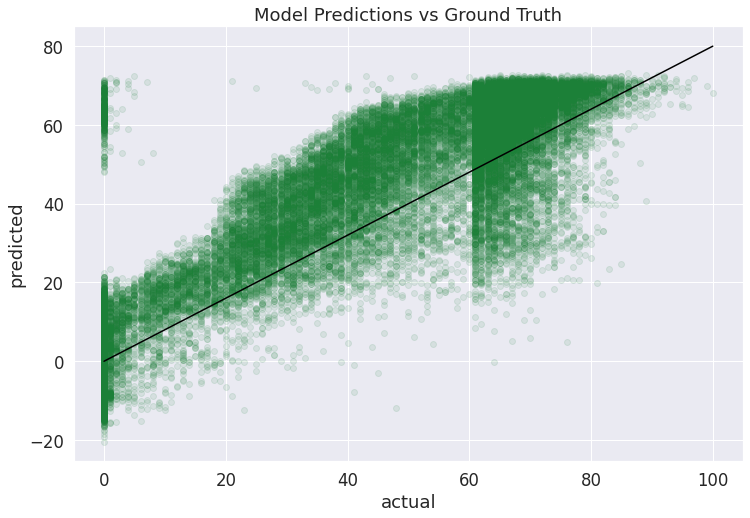

In [32]:
score_model(y,y_pred)

Mean Absolute Error = 8.7 which means our predicions were missed by 8 points on average. This can mean 8  points too high or 8 points too low on our popularity scores prediction. Another observation is that our model is not predicting any values above 80. We will look more into that in the next part.

In [33]:
np.corrcoef(y, y_pred)

array([[1.        , 0.90682706],
       [0.90682706, 1.        ]])

##Analysing why the model will not predict values above 80 while showing actual values up to 100.
We wanted to find out why our model would not predict values above 80 so we made a Linear Regression Model on `popularity` values higher than 60 and fit the model.


In [34]:
lr_high = LinearRegression()

In [35]:
X = pop_df[['year','danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
       'loudness',  'acousticness', 'speechiness', 'valence']]
y= pop_df['popularity']

In [36]:
lr_high.fit(X,y)

LinearRegression()

In [37]:
y_pred = lr_high.predict(X)

In [38]:
def score_model(y, y_hat):
  mae_score = mean_absolute_error(y, y_pred)
  print(f'MAE = {np.round(mae_score, 4)}')

  pearson = np.corrcoef(y, y_hat)[0, 1]
  print(f'R^2 = {np.round(pearson**2, 4)}')

  plt.figure(figsize=(12, 8))
  
  plt.scatter(y, y_hat, alpha=0.1,  color = '#1c8038')
  plt.xlabel('actual')
  plt.ylabel('predicted')
  #plt.plot([min(y), max(y)], [0,80], color='black')
 # plt.plot([0,100],[0,100], color = 'gray')
  plt.title('Model Predictions vs Ground Truth');

MAE = 4.4534
R^2 = 0.0571


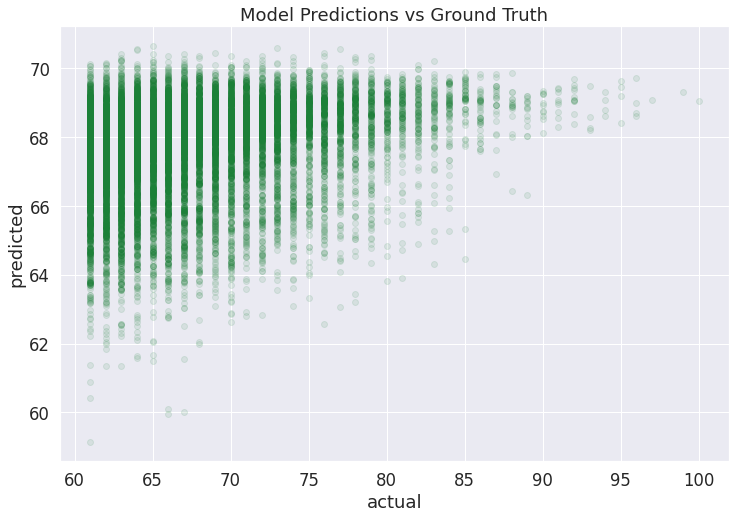

In [39]:
score_model(y,y_pred)

In [40]:
np.corrcoef(y, y_pred)

array([[1.        , 0.23892757],
       [0.23892757, 1.        ]])

Even after making a new model with only high values of popularity score we couldn't get predictions higher than 80.

#Findings & Suggestions 
After looking at our data, cleaning, analysing and making models we found that newer songs tend to be more popular. A few features that help a song become more popular are: more energy and loudness, and less acousticness.
We would suggest adding more newer songs to the dataset to balance it out with the older songs which are less popular. Since Spotify was founded in 2006 it is reasonable that songs after 2006 have more play counts than the ones made in the early 1920's. 